# Equipo 7
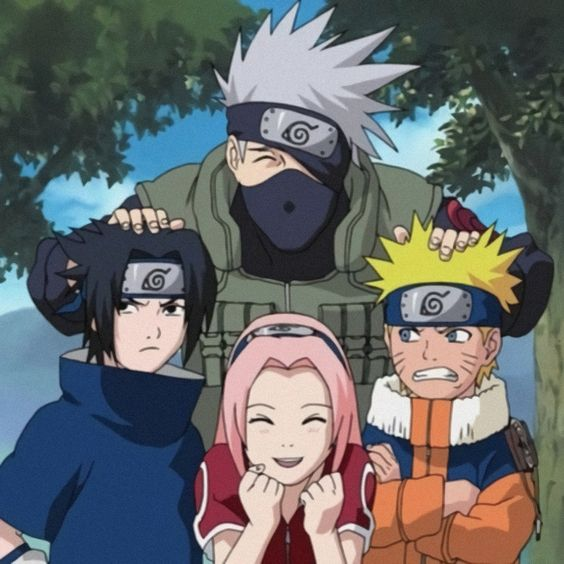

## INTRODUCCIÓN

El 23 de marzo de 2020 ocurrió un acontecimiento que cambio la vida de millones de personas, el Covid-19.
Para poder identificar a las personas infectadas es necesario realizar una tomografía computarizada (TC), para esto el radiólogo debe de examinar todos los cortes axiales brindados por la computadora para poder identificar las zonas afectadas en los pulmones.

# OBJETIVO
Nuestro reto es poder ayudar a los radiólogos a encontrar alguna forma más eficiente de encontrar las zonas más afectadas por el covid-19, mediante la segmentación de imágenes.

La segmentación de imágenes es de gran utilidad para poder detectar las zonas afectadas. Ya que los médicos pueden aislar las zonas con mayor virus, crear planes de mejora personalizados y dar un seguimiento al tratamiento de dicho paciente.

## IMPLICACIONES ÉTICAS

Siempre se deben proteger los datos de los pacientes. La manipulación de imágenes médicas (como las tomografías) implica la gestión de datos sensibles que deben cumplir con normativas estrictas de privacidad, como el Reglamento General de Protección de Datos (GDPR) en Europa, donde resaltan que es crucial garantizar que los datos sean anónimos para que los datos no sean utilizados con otros fines.

Los modelos entrenados con IA no solo deben ser precisos, sino que deben poder ser interpretables, por lo que al trabajar para personas que no son del campo de Tecnologías, debemos de mostrar interpretaciones claras con las que los médicos puedan tomar las mejores decisiones.

Aunque la IA puede ayudar a detectar enfermedades como el COVID, siempre debe estar bajo la supervisión de profesionales médicos. Los resultados obtenidos por los modelos de IA deben ser revisados por especialistas, asegurando que las decisiones finales sean tomadas por médicos, quienes son responsables del diagnóstico y tratamiento del paciente.


In [1]:
# Instalación de librerías
! pip install segmentation_models_pytorch
! pip install kaggle

In [2]:
# Importación de librerías
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Recorre todos los directorios y archivos en la ruta '/kaggle/input'
for dirname, _, filenames in os.walk('kaggle/input'):
    # Itera sobre cada archivo en los directorios encontrados
    for filename in filenames:
        # Imprime la ruta completa del archivo
        print(os.path.join(dirname, filename))

kaggle/input\covid-segmentation\images_medseg.npy
kaggle/input\covid-segmentation\images_radiopedia.npy
kaggle/input\covid-segmentation\masks_medseg.npy
kaggle/input\covid-segmentation\masks_radiopedia.npy
kaggle/input\covid-segmentation\test_images_medseg.npy


### Cargar las imágenes en archivos numpy y convertirlas float32 y las máscaras a int8

* prefix contiene el path de las imágenes
* images_radiopedia contiene las imágenes del dataset de Radiopedia
* mask_radiopedia contiene las máscaras de segmentación del dataset de Radiopedia
* images_medseg contiene las imágenes del dataset de MedSeg
* mask_medseg contiene las máscaras de segmentación del dataset de MedSeg
* test_images_medseg contiene las imágenes de test del dataset de MedSeg

In [4]:
prefix = 'kaggle/input/covid-segmentation/'
images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)
# Imprimir total de imágenes
print(f'Total de imágenes: {images_radiopedia.shape[0]}')

Total de imágenes: 829


## FUNCIÓN VISUALIZE:
La función visualize te permite ver un conjunto de imágenes, sus máscaras de segmentación (si las tienes), y las predicciones que ha hecho un modelo. Esto es útil para comprobar visualmente cómo de bien el modelo está segmentando las imágenes comparándolas con las máscaras reales.
* image_batch: Es el lote de imágenes que visualizará.
* mask_batch: Lote de máscaras de segmentación correspondientes a las imágenes.
* pred_batch: Lote de predicciones de segmentación del modelo.
* num_samples: Cantidad de imágenes que se van a mostrar (en nuestro caso, 8).
* hot_encode: Booleano, da a saber si las imágenes tienen one hot encoding.

### ¿Qué hace la función?
- Crea una cuadrícula de num_samples columnas. La primera tiene las imágenes originales y las otras filas muestran las máscaras y/o predicciones para cada clase (si es que hay).
- Se muestran en primera fila las imágenes del lote image_batch. Si están en one-hot encoding, muestra el primer canal en escala de grises, sino, muestra la imagen completa.
- Muestra las máscaras si es que se dan máscaras mask_batch en las siguientes filas. Cada fila es una clase distinta de máscara.
- Si hay predicciones (pred_batch) se comparan con las máscaras. El canal rojo muestra las predicciones del modelo y el verde las máscaras reales.

### Flujo
1. Se calcula el número de clases que hay en las máscaras (si es que hay)
2. Se crea una cuadrícula de subplots con filas = clases+1 para las imágenes
3. Recorre las imágenes:
    1. Muestra cada imagen en la primera fila
    2. Si hay máscaras, muestra cada clase en las otras filas (las que no son la primera fila)
    3. Si hay predicciones, las muestra junto con las máscaras, comparando la predicción en rojo y la máscara en verde.
4. Muestra la visualización.

In [5]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    # Calcula núm. de clases en las máscaras. Si no hay clases, se devuelve 0
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    # Crea una cuadrícula con la cantidad de columnas de num_samples y filas del tamaño de num_classes +1.
    # La primera fila está destinada para las imágenes y las siguientes para las máscaras.
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        # Si existen clases, se pone su respectiva imagen en la i fila.
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            # Si hay one hot encoding, muestra la imagen en escala de grises.
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            # Sino, muestra la imagen completa (pues supone que solo hay un canal)
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            # Ciclo que recorre las clases de la máscara
            for j in range(num_classes):
                if pred_batch is None:
                    # Si no hay predicciones, se toma la máscara de la clase j de la imagen i
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    # Sino, se hace una matriz de ceros con las mismas dimensiones que la máscara con 3 canales de color RGB
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    # Predicciones de rojo. Si la predicción es mayor a 0.5, se muestra. 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    # Sino, se muestra en verde la máscara original de la clase j.
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

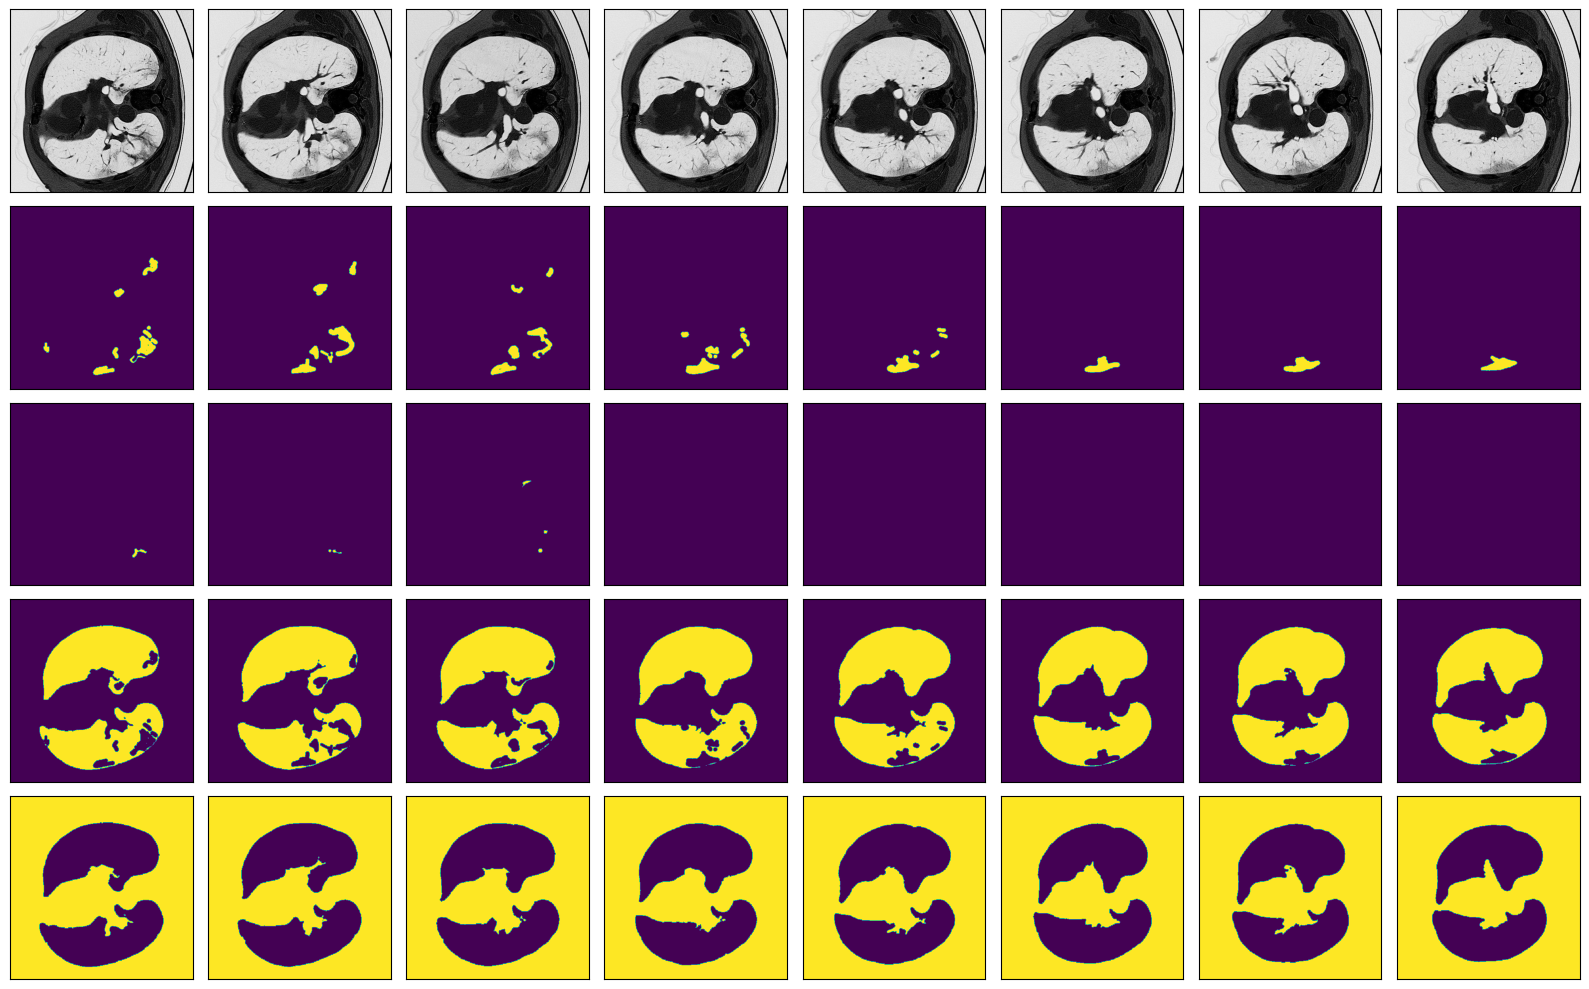

In [6]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

## FUNCIÓN ONE HOT:

La función onehot_to_mask convierte una máscara segmentada que está codificada en formato one-hot (H, W, K) en una representación de imagen más comprensible utilizando una paleta de colores o valores predefinidos. Esto es útil para visualizar máscaras de segmentación de manera más clara, asignando a cada clase un color específico basado en la paleta.

* mask: Tiene los parametros de H(Altura), W(ancho) y K(es el número de clases)
* palette: Una lista de listas, donde cada sublista contiene valores o colores que corresponden a cada clase en la imagen segmentada. Por ejemplo, si hay 3 clases, cada clase tendrá su color asignado desde esta paleta.

### ¿Qué hace la función?
- Para cada pixel en la máscara segmentada, la función determina a qué clase pertenece usando np.argmax, que devuelve un índice de clase para cada pixel.
- Usando esos índices de clase, la función usa la paleta para mapear cada clase a su color correspondiente, generando una representación en color de la máscara.
- Finalmente, la función devuelve una imagen con colores aplicados para la clase, con las dimensiones de (H,W,C) donde C son los valores de los colores.

### Flujo
1. La función toma la máscara segmentada "mask" y usa "np.argmax" para encontrar el índice de la clase con el valor más alto en cada pixel, de manera que la máscara pasa de (H, W, K) a (H, W), donde cada valor corresponde a un índice de clase.
2. Convierte la lista "palette" en un arreglo para simplificar el mapeo.
3. Después, se mapean los índices de clases a los valores de colores definidos en "palette", creando una imagen de forma (H, W, C).
4. Finalmente, se devuelve la imagen con los colores aplicados para cada clase, dando una visualización más clara de la segmentación.


Esta función es útil para visualizar máscaras segmentadas de manera más intuitiva, ya que convierte una representación abstracta (codificación one-hot) en una imagen con colores fácilmente identificables por clase.

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


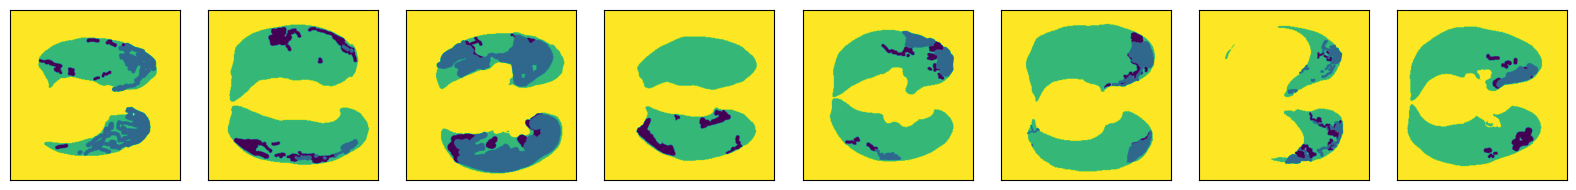

In [7]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    H = Altura (Height)
    W = Ancho (Weight)
    K = Clases 
    """
    # Toma la máscara con One Hot de la forma (H, W, K), para cada pixel, toma la clase con el jvalor más alto a lo largo del eje -1 (el de las clases), dando como resultado un arreglo de x con (H, W) con los índices de las clases asignadas a cada pixel.
    x = np.argmax(mask, axis=-1)
    # Convierte la lista palette en un arreglo colour_codes que contiene los identificadores de color de cada clase.
    colour_codes = np.array(palette)
    # Usa el arreglo x de índices para convertirlo a un array de enteros (sin negativos). Usa los índices para asignar los colores de palette a cada pixel. Como resultado, hay una reconstrucción a color de la imagen.
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    # Se devuelve x (máscara original) con los colores de las clases aplicados
    return x

palette = [[0], [1], [2],[3]]
# Se llama a la función onehot_to_mask con la máscara de masks_radiopedia y la paleta de colores palette para devolver una imagen con colores de la máscara aplicados. Se usa squeeze para simplificar su dimensión.
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

# Se repite el proceso pero para masks_medseg  
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Imprimir formas de las máscaras originales (las que tienen One Hot Encoding) y las con color.
print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

## FUNCIÓN PREPROCESS_IMAGES:
Esta función hace un preprocesamiento de un conjunto de imágenes limitados a un rango de pixeles definidos, eliminando valores extremos y normalizando las imágenes usando la media y la desviación estándar. 
* images_arr: Un arreglo de imágenes, donde cada píxel tiene un valor que representa la intensidad de la imagen. El arreglo puede tener dimensiones (H, W) o más, dependiendo del formato de las imágenes.
* mean_std: Un parámetro (que es opcional) que contiene la media y la desviación estándar previamente calculadas. Si se proporciona, las imágenes se normalizan utilizando estos valores. Si no se proporciona, la función calculará la media y desviación estándar a partir de los datos válidos del arreglo de imágenes.

### ¿Qué hace la función?
- Los valores de los pixeles por encima de 500 se quedan en 500, y los que están debajo de -1500 se quedan en -1500, de manera que evitamos valores extremos o ruido que pueda afectar a la calidad de las imágenes procesadas.
- Se calculan los percentiles de 5 y 95 de las imágenes. Los valores dentro de este rango se consideran como válidos y son normalizados restándoles la media y dividiéndolos entre su desviación estándar, haciendo que se escalen los valores.
- Se devuelve un conjunto de imágenes procesadas y los valores de media y desviación estándar.

### Flujo
1. Se establecen como límite de los pixeles 500 para los valores extremos positivos y -1500 para los valores extremos negativos.
2. Se calculan los percentiles de 5 y 95 del arreglo de las imágenes para identificar el rango de valores válidos, creando un nuevo arreglo con estos valores.
3. Se calcula la media y la desviación estándar si no se proporcionan
4. Se normalizan las imágenes restando la media y dividiendo el resultante entre la desviación estándar, de modo que tengan una distribución normalizada.
5. Se devuelve el arreglo de imágenes normalizadas y sus valores de media y desviación estándar.

Es útil para preparar imágenes médicas para su análisis/entrenamiento de modelos, asegurando que estén dentro de un rango razonable y normalizadas, facilitando su comparación y mejora la calidad de los modelos de aprendizaje.

In [8]:
def preprocess_images(images_arr, mean_std=None):
    # Los valores en el arreglo de imágenes mayores a 500, se limitan a 500 (para evitar sesgos)
    images_arr[images_arr > 500] = 500
    # Los valores en el arreglo de imágenes menores a 1500, se quedan en -1500 (para evitar sesgos)
    images_arr[images_arr < -1500] = -1500
    # Se calculan los percentiles 5 y 95 del arreglo de las imágenes, que se usarán para identificar el rango de valores válidos, pues los valores dentro de estos serán considerados para calcular la media y desviación estándar.
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    # Se hace un arreglo que contiene los valores dentro de estos percentiles. Los valores fuera de estos no se toman en cuenta para evitar que los valores extremos afecten a los cálculos de media y desviación estándar.
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    # Si no se dio mean_std se calcula la media y la desviación estándar a partir de los datos de images_arr_valid
    # Si sí se dio mean_std, pues ya no se vuelven a calcular  
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    # Después, se normalizan las imágenes restando la media y dividiendo entre la desviación estándar, de modo que se escalen los valores con media de 0 y desviación estándar de 1
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')    
    return images_arr, (mean, std)

# Se procesan las imágenes de rafiopedia y sí se les da la media y la desviación estándar
images_radiopedia, mean_std = preprocess_images(images_radiopedia)
# Se procesan las imágenes de medseg, pero acá sí se usa la media y desviación estándar calculadas previamente.
images_medseg, _ = preprocess_images(images_medseg, mean_std)
# Se procesan las test_images_medseg de igual manera que la anterior
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


## FUNCIÓN PLOT HISTS

Genera un histograma de los valores de los píxeles de un conjunto de imágenes. Al mandar otro conjunto de imágenes nos graficara el histograma en el mismo gráfico, permitiendo comparar la distribución de los pixeles entre los conjuntos. Permitiendo observar caracterísitcas como el rango de valores, la presencia de valores extremos y la normalización de los datos.
* images1: Arreglo de imágenes para el primer histograma.
* images2: Arreglo de imágenes para el segundo histograma (que queremos comparar).

### ¿Qué hace la función?
- Crea un histograma de los valores de los pixeles del primer conjunto de imágenes (images1) aplanando el arreglo para representar todos los pixeles en un solo gráfico. Se definen 100 barras para el histograma y se normaliza el área bajo el histograma sea igual a 1.
- Si se da  un segundo arreglo de imágenes (images2) se hace lo mismo y se le pone un aopacidad de 0.5 para que se note la diferencia entre un conjunto y otro. 
- Se muestran los histogramas.

Esta función es útil para comparar la distribución de los píxeles entre dos conjuntos de imágenes y verificar características como la normalización, valores extremos o diferencias en los rangos de intensidad de los píxeles.

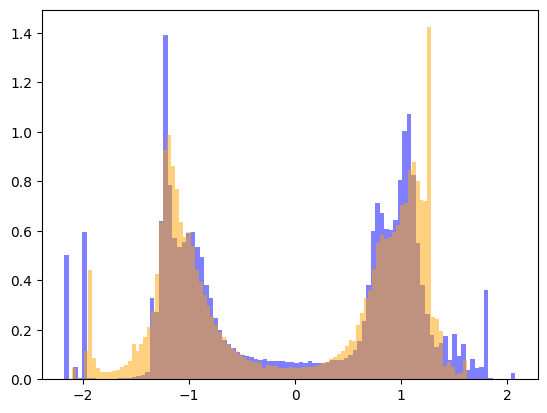

In [9]:
def plot_hists(images1, images2=None):
    # Se hace un histograma para la primera imagen, donde ravel() convierte el arreglo de images1 a una forma aplanada para hacer el histograma.bins 100 define 100 barras para el histograma. density = true dice que el área total del histograma sea 1, color azul y con opacidad de 0.5 si se dan 2 parámetros de entrada.
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        # Si se dio otro conjunto de imágenes, se hace lo mismo que con image1 pero se punta de naranja y con opacidad de 0.5
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();
    
# Llamada a la función con el conjunto de imágenes de test_images_medseg e images_radiopedia
plot_hists(test_images_medseg, images_radiopedia)

In [10]:
# Convierte una máscara de One Hot Encoding de masks_radiopedia a una máscara de colores con la paleta de colores palette. Se usa squeeze para simplificar su dimensión, obteniendo una forma de (H, W).
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
# Hace lo mismo que lo anterior pero con masks_medseg
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

# Se hace una lista val_indexes con números del 0 al 23 para los datos de validación y otra train_indexes con números del 24 al 99 para entrenamiento
val_indexes, train_indexes = list(range(24)), list(range(24, 100))

# Concatena las imágenes de medseg (train_indexes) y radiopedia para el conjunto imágenes de entrenamiento.
train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
# Concatena las máscaras del conjunto de entrenamiento, es decir, las máscaras recuperadas de masks_medseg_recover(para los train_indexes) y masks_radiopedia_recover, creando el conjunto de máscaras de entrenamiento.
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
# Selecciona las imágenes de validación, donde se extrae las imágenes de images_medseg que corresponden a los índices de validación (val_indexes) para formar el conjunto de imágenes de validación.
val_images = images_medseg[val_indexes]
# Selecciona las máscaras de validación, donde se extrae las máscaras de masks_medseg_recover que corresponden a los índices de validación (val_indexes) para formar el conjunto de máscaras de validación.
val_masks = masks_medseg_recover[val_indexes]

# Se calcula el tamaño del lote de validación, que es el número de elementos en val_masks.
batch_size = len(val_masks)
print(f'Batch size: {batch_size}')
# Se libera memoria eliminando los arreglos y variables que ya no son necesarias.
del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

Batch size: 24


## IMPORTACIONES 
tensorflow: Es una biblioteca que nos ayudara para construir y entrenar modelos de machine learning. Junto con el procesamiento de imágenes.

albumentation: Se utiliza para aumentos de imágenes de manera eficiente.

In [11]:
# Considerar instalar CV2 y albumentations
import tensorflow
import albumentations
import cv2

512 => El tamaño original de las imágenes
256 => El tamaño objetivo al que se reducirán las imágenes

In [12]:
SOURCE_SIZE = 512
TARGET_SIZE = 256

## TRANSFORMACIONES PARA EL CONJUNTO DE ENTRENAMIENTO Y VALIDACIÓN

El uso de transformaciones (como las de train_augs y val_augs) sirve para aumentar los datos cuando se trabaja con imágenes, pues generan nuevas muestras de imágenes de entrenamiento al aplicar rotaciones, recortes aleatorios y flips, mejorando la robustez y generalización del modelo. Al hacer esto, el modelo aprende a ser más flexible con diferentes variaciones de datos que son esenciales para la segmentación o clasificación de imágenes.

Las transformaciones del conjunto de validación son simples para asegurar la consistencia de los datos evaluados. El objetivo no es aumentar la cantidad de muestras, sino que es mantener la exactitud de las imágenes para evaluar el rendimiento del modelo.

### Flujo
1. Las imágenes del conjunto de entrenamiento se rotan con un ángulo aleatorio (hasta 360°) para que el modelo aprenda a reconocer patrones independientemente de la orientación del objeto. Las partes vacías se rellenan con los bordes de la imagen.
2. Después, se recortan las imágenes de manera aleatoria tomando entre el 75% y el 100% de su tamaño original. Esto ayuda al modelo a aprender a reconocer objetos que no siempre estarán centrados o del mismo tamaño. Después del recorte, las imágenes se redimensionan al tamaño esperado de entrada del modelo.
3. Finalmente, las imágenes se voltean horizontalmente con una probabilidad del 50% para que el modelo sea un poco más flexible. 
4. En la validación, las imágenes solo se redimensionan al tamaño de entrada (sin moverse, redimensionarse, no), de modo que la validación permanezca consciente y no instroduzca una variable que pueda distorsionar al modelo en vez de ayudarlo.

In [13]:
# Se usa la librería albumentations.Compose para combinar múltiples transformaciones que se aplicarán de manera secuencial a las imágenes de entrenamiento, esto con el fin de aumentar la cantidad de datos de entrenamiento.
train_augs = albumentations.Compose([
    # Se gira la imagen aleatoriamente en un rango de 360 grados con una probabilidad de que rote del 90% y si la rotación deja partes vacías, se rellenan con el borde más cercano.
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    # Se recorta la imagen aleatoriamente con un tamaño  de recorte entre el 75% y el 100% del tamaño original de la imagen, y se redimensiona a un tamaño de 256x256 píxeles. Se usa la interpolación (vecino más cercano) al redimensionar, que es la más adecuada para máscaras o imágenes segmentadas pues no se generan nuevos valores.
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    # Se voltea horizontalmente la imagen con una probabilidad del 50%.
    albumentations.HorizontalFlip(p=0.5),

])

# Para el conjunto de validación, se aplican transformaciones más simples (pues no se necesita aumentar la cantidad de datos de validación, sino mantener la consistencia de las imágenes procesadas).
val_augs = albumentations.Compose([
    # Se redimensiona la imagen a un tamaño fijo y se interpola con el vecino más cercano para preservar la estructura de la imagen, especialmente en la segmentación, donde los valores de los pixeles son muy importantes.
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [14]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
import torch

Nos aseguramos de entrenar usando nuestra tarjeta grafica **RTX 4070**/**RTX 3090** de pendiendo cuando lo corramos

In [15]:
import torch.cuda as cuda
if cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## DATASET
En el siguiente código definiremos la clase Dataset que maneja imágenes y máscaras, aplicando aumentaciones y procesamiento. Luego, se creara dos conjuntos de datos para entrenamiento y validación. Ocupamos DataLoader para facilitar la iteración por estos conjuntos en el entrenamiento de modelo, permiten trabajar con los datos en pequeños lotes, es eficiente en términos de memoria y tiempo de entrenamiento. 

In [16]:
class Dataset: 
    # Instancia de la clase Dataset que contiene el conjunto de imágenes, el conjunto de máscaras (correspondientes a las imágenes) y las transformaciones que se aplicarán a las imágenes y máscaras.  
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        # Se inicializan las imágenes, máscaras y transformaciones que se aplicarán a las imágenes y máscaras, se define la media y la desviación estándar que se usará para normalizar las imágenes. 
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]
    
    # Método para accerder a un ítem, permite que una instancia del Dataset se comporte como una lista, donde se puede acceder a los elementos por índice.
    def __getitem__(self, i):
        # Se accede a la imagen y la máscara en la posición i del conjunto de datos.
        image = self.images[i]
        mask = self.masks[i]
        
        # Si se dieron transformaciones, se aplican a la imagen y la máscara.
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            # Se convierte el array de la imagen a una imagen PIL
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        # Si no se dieron transformaciones, se convierte el array de la imagen a una imagen PIL.
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        # Se convierte la imagen a un tensor y se normaliza.
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    # Método que obtiene el tamaño de un conjunto de datos, devuelve el número de imágenes en el dataset.
    def __len__(self):
        return len(self.images)
    
    # Método para dividir en parches, es decir, toma una imagen y una máscara y las divide en parches.
    def tiles(self, image, mask):

        # Divide la imagen en bloques (parches) de tamaño 512x768.
        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        # Ajusta la vista del tensor para manejar los bloques.
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        # Cambia el orden de los ejes del tensor para que los parches tengan una forma adecuada.
        img_patches = img_patches.permute(1,0,2,3)
        
        # Se divide la máscara de manera similar a la imagen, con bloques de 512x768.
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
# Se crea una instancia de la clase Dataset para el conjunto de entrenamiento, con las imágenes de entrenamiento, las máscaras de entrenamiento y las transformaciones de entrenamiento.                
train_dataset = Dataset(train_images, train_masks, train_augs)
# Se crea una instancia de la clase Dataset para el conjunto de validación, con las imágenes de validación, las máscaras de validación y las transformaciones de validación.
val_dataset = Dataset(val_images, val_masks, val_augs)       

# Se crea un DataLoader para el conjunto de entrenamiento, que permite iterar sobre los datos en lotes, además, las imágenes se cargan en orden aleatorio en cada época.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Se crea un DataLoader para el conjunto de validación, que permite iterar sobre los datos en lotes de tamaño definido en batch_size, pero sin mezclar las imágenes (para mantener el orden).
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## FUNCIÓN MASK TO ONE HOT
Toma una máscara de segmentación (una imagen es donde cada píxel tiene un valor) y la convierte en una representación one-hot encoded. Lo que significa que cada píxel será un vector donde solo la posición correspondiente a la clase 1, y las demás posiciones son 0, dando como resultado un vector binario que indica la clase a la que pertenece el píxel.


colour [0]
colour [1]
colour [2]
colour [3]


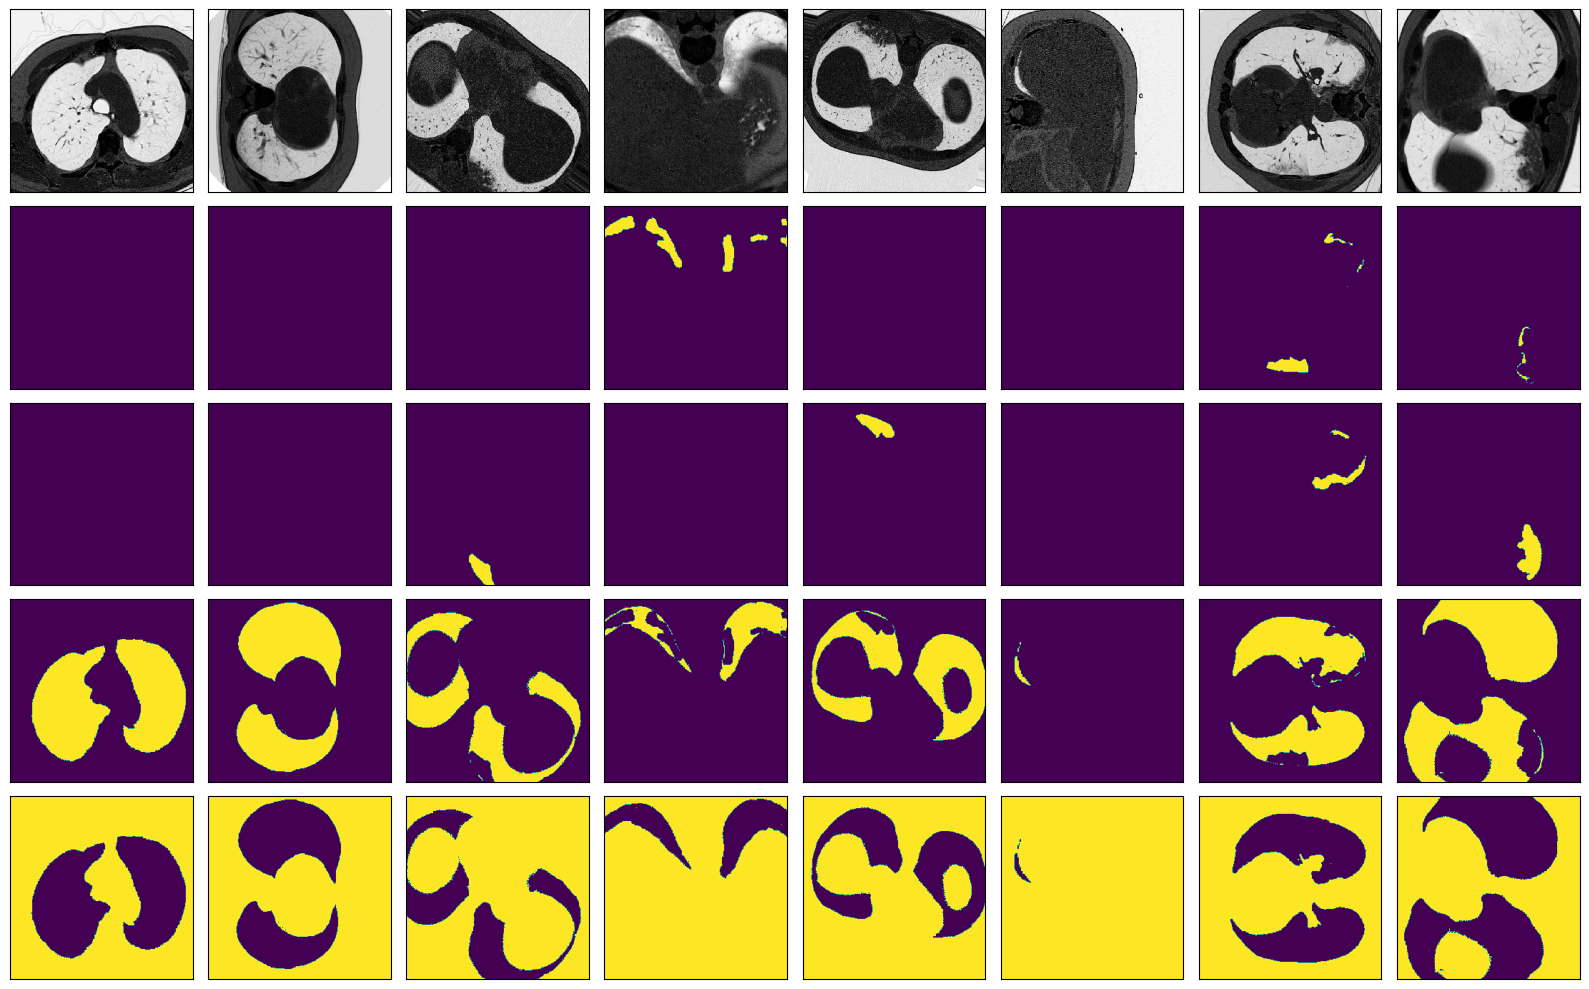

In [17]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        print('colour',colour)
        equality = np.equal(mask, colour)
        # print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
# visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)

## FUNCIÓN PIXEL ACCURACY
Calcula el porcentaje de píxeles correctamente predichos por un modelo de segmentación de imágenes.
Tomando la salida del modelo y la máscara verdadera, comparando los valores predichos con los reales.

In [18]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

## FUNCIÓN MIoU (Mean Intersection over Union)
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mtext>mIoU</mtext><mo>=</mo><mfrac><mn>1</mn><mi>n</mi></mfrac><munderover><mo>∑</mo><mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow><mi>n</mi></munderover><mfrac><mrow><mi mathvariant="normal">∣</mi><msub><mi>A</mi><mi>i</mi></msub><mo>∩</mo><msub><mi>B</mi><mi>i</mi></msub><mi mathvariant="normal">∣</mi></mrow><mrow><mi mathvariant="normal">∣</mi><msub><mi>A</mi><mi>i</mi></msub><mo>∪</mo><msub><mi>B</mi><mi>i</mi></msub><mi mathvariant="normal">∣</mi></mrow></mfrac></mrow><annotation encoding="application/x-tex">\text{mIoU} = \frac{1}{n} \sum_{i=1}^{n} \frac{|A_i \cap B_i|}{|A_i \cup B_i|} 
</annotation></semantics></math>
Evalúa qué tan bien el modelo predice las regiones correctas para diferentes clases en la imagen, calculando el promedio de la intersección y la unión entre las áreas predichas y las áreas de referencia (ground truth) para cada clase. Es una métrica especialmente útil cuando tenemos múltiples clases en una tarea de segmentación, como por ejemplo en la segmentación semántica de imágenes.

El IoU (Intersection over Union) para una sola clase se calcula dividiendo el número de píxeles donde la predicción y el ground truth coinciden (intersección) por el número de píxeles en la unión de ambas máscaras (donde al menos una es positiva).

$\text{mIoU} = \frac{1}{n} \sum_{i=1}^{n} \frac{|A_i \cap B_i|}{|A_i \cup B_i|}$


In [19]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

## Función IoU (Intersection over Union)
La IoU nos permite medir qué tan bien se solapa (intersecta) el área predicha con el área de referencia (ground truth). Se calcula comparando el área en común entre ambas máscaras (predicción y referencia) con el área total que abarcan combinadas (unión). La fórmula es:
$$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$$

- A es la máscara predicha
- B es la máscara de referencia



In [20]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))
    if u == 0:
        result = 1
    else:
        result = i/u
    return result

## Creación de un modelo basado en la arquitectura de UNet

Crear un modelo Unet con el encoder de efficientnet-b2, con 1 canal de entrada, pesos preentrenados de imagenet, 4 clases, activación nula, 5 capas de profundidad en el encoder y 5 canales de salida en el decoder.

In [21]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

#decoder_attention_type ='scse'

## Función Fit
Esta función entrena un modelo de redes neuronales profundas usando PyTorch. El propósito es entrenar y validar el modelo en un número de épocas definido, monitorear las métricas de rendimiento como la pérdida (loss), el mIoU (Mean Intersection over Union) y la precisión (accuracy) tanto en el conjunto de entrenamiento como en el conjunto de validación, además de ajustar los pesos del modelo usando un optimizador y programar el ajuste de la tasa de aprendizaje usando un scheduler.
* epochs: El número de épocas a entrenar.
* model: El modelo de red neuronal que se entrena.
* train_loader: El DataLoader para el conjunto de entrenamiento que proporciona los lotes de datos.
* val_loader: El DataLoader para el conjunto de validación.
* criterion: La función de pérdida (CrossEntropyLoss) que se utilizará para calcular la pérdida entre la predicción y el valor real.
* optimizer: El optimizador que se utiliza para actualizar los pesos del modelo (por ejemplo, Adam).
* scheduler: El programador de tasa de aprendizaje que ajusta la tasa de aprendizaje durante el entrenamiento.
* patch: Parámetro opcional que parece no usarse en la función actual.


In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache() #clear cache
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                                        #loss
                    loss = criterion(output, mask)    
                    ''' Criterion: '''                              
                    test_loss += loss.item()
                    
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0: #save model each 5 epochs
                    print('saving model...')
                    torch.save(model, 'Kaggle/Output/Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 5:
                    print('Loss not decrease for 5 times, Stop Training')
                    break
            else:
                not_improve = 0
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

Preparar el modelo para un entrenamiento eficiente y efectivo. Ajustar parámetros críticos (la tasa de aprendizaje y la regularización de los pesos), permitiendo que el modelo sea capaz de aprender de manera óptima sin sobreajustarse a los datos. La integración de un scheduler dinámico de la tasa de aprendizaje y el monitoreo constante de las métricas de evaluación aseguran que el proceso de entrenamiento sea robusto y esté diseñado para maximizar el rendimiento del modelo en tareas de segmentación de imágenes.

In [23]:
max_lr = 1e-4
epoch = 10
weight_decay = 1e-6

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.263 
Epoch:1/10.. Train Loss: 1.402.. Val Loss: 1.263.. Train mIoU:0.169.. Val mIoU: 0.227.. Train Acc:0.386.. Val Acc:0.528.. Time: 0.27m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.263 >> 0.387 
Epoch:2/10.. Train Loss: 0.405.. Val Loss: 0.387.. Train mIoU:0.443.. Val mIoU: 0.412.. Train Acc:0.923.. Val Acc:0.901.. Time: 0.23m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.387 >> 0.293 
Epoch:3/10.. Train Loss: 0.149.. Val Loss: 0.293.. Train mIoU:0.463.. Val mIoU: 0.417.. Train Acc:0.966.. Val Acc:0.905.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.293 >> 0.252 
saving model...
Epoch:4/10.. Train Loss: 0.092.. Val Loss: 0.252.. Train mIoU:0.486.. Val mIoU: 0.476.. Train Acc:0.972.. Val Acc:0.920.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.252 >> 0.210 
Epoch:5/10.. Train Loss: 0.073.. Val Loss: 0.210.. Train mIoU:0.598.. Val mIoU: 0.557.. Train Acc:0.979.. Val Acc:0.935.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:6/10.. Train Loss: 0.062.. Val Loss: 0.212.. Train mIoU:0.647.. Val mIoU: 0.575.. Train Acc:0.982.. Val Acc:0.936.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.212 >> 0.207 
Epoch:7/10.. Train Loss: 0.058.. Val Loss: 0.207.. Train mIoU:0.688.. Val mIoU: 0.582.. Train Acc:0.983.. Val Acc:0.937.. Time: 0.24m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.207 >> 0.193 
Epoch:8/10.. Train Loss: 0.055.. Val Loss: 0.193.. Train mIoU:0.725.. Val mIoU: 0.607.. Train Acc:0.984.. Val Acc:0.941.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 0.193 >> 0.191 
Epoch:9/10.. Train Loss: 0.050.. Val Loss: 0.191.. Train mIoU:0.754.. Val mIoU: 0.615.. Train Acc:0.985.. Val Acc:0.942.. Time: 0.25m


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:10/10.. Train Loss: 0.050.. Val Loss: 0.192.. Train mIoU:0.746.. Val mIoU: 0.614.. Train Acc:0.985.. Val Acc:0.942.. Time: 0.24m
Total time: 2.48 m


In [24]:
# Guardar el modelo
torch.save(model, 'Kaggle/Output/Unet-efficientnet.pt')

### Graficas de Loss, Score, Accuracy

In [25]:
# Graficar la pérdida
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
# Graficar el score 
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
# Graficar la precisión
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

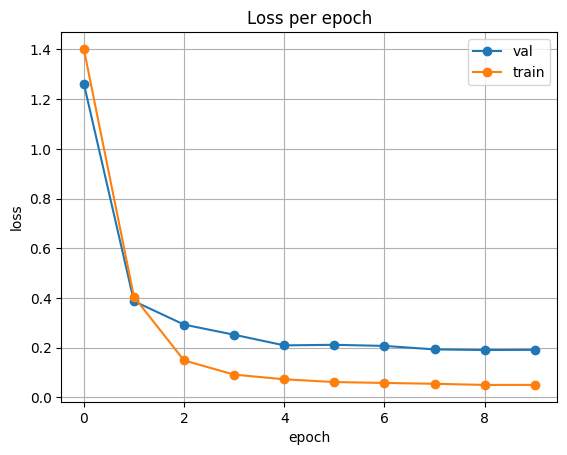

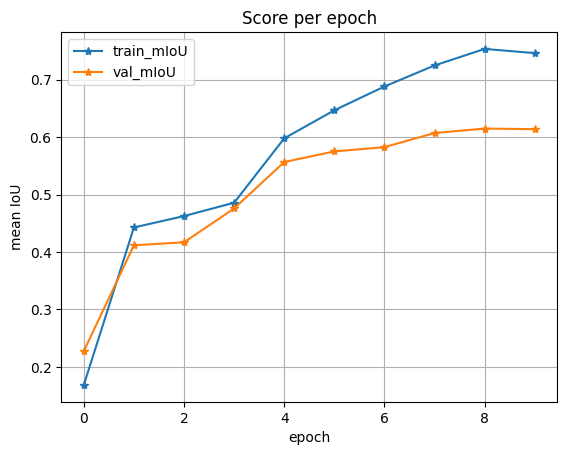

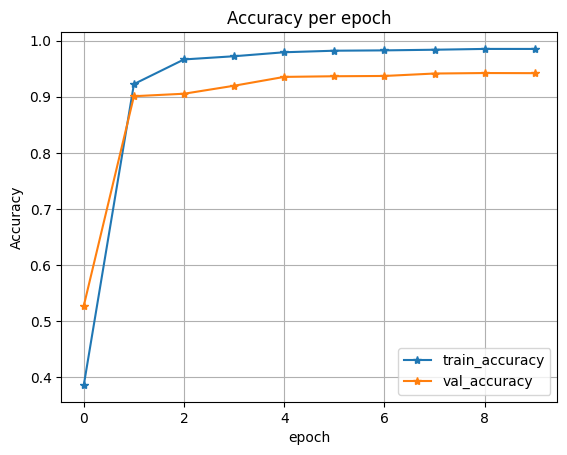

In [26]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# FUNCIÓN PREDICT IMAGE MASK mIoU

Toma el modelo de segmentación de imágenes, toma la imágen de referencia (ground truth) y devuelve la máscara predicha, el puntaje de mIoU y las predicciones del modelo. Retorna la máscara resultante junto con las predicciones del modelo.

In [27]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    
    
    with torch.no_grad():
        
        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)
        
        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

# PREDICT IMAGE MASK PIXEL

Nos ayudara para poder predecir una máscara  de clases a partir de una imagen dada utilizando el modelo de segmentación, calcula la precisión a nivel píxel, que también predicien los pixeles con la imagen original y devuelve la máscara resultante junto con la precisión obtenida.

In [28]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

# MASK TO ONEHOT

Convierte una máscara de segmentación basada en colores (o valores) en una representación one-hot enconding, donde cada pixel tiene un vector que  indica a qué clase pertenece.

In [29]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [30]:
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

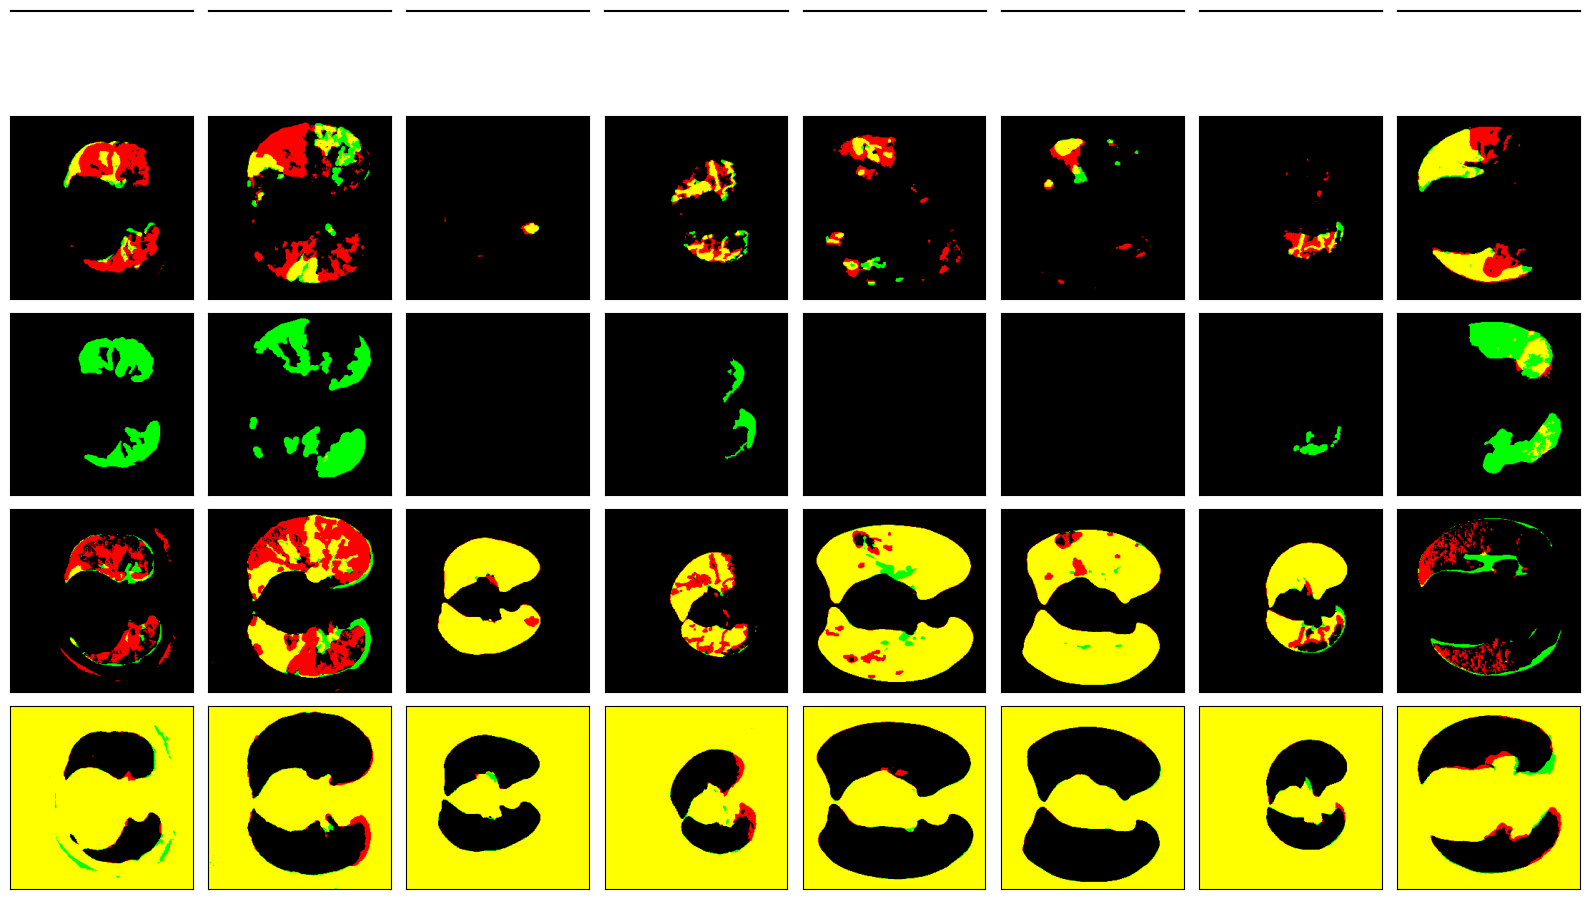

In [31]:
# Assuming 'output' is the tensor that needs to be moved to the CPU
output_cpu = output.cpu().numpy()

# Pass the CPU tensor to the visualize function
visualize(image, semantic_map, pred_batch=output_cpu)

# yellow is TP, red is FP, green is FN

In [32]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [33]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

  0%|          | 0/1 [00:00<?, ?it/s]

[0.6138031307173784]

In [34]:
del train_images
del train_masks

# FUNCIÓN TEST PREDICT

Toma una imagen, la preprocesa (convirtiéndola a tensor y normalizándola), la pasa por el modelo de segmentación en modo de evaluación, aplica una función softmax para obtener probabilidades, y devuelve las predicciones en una forma fácilmente manejable para cada píxel en la imagen.

In [35]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

Toma un lote de imágenes médicas que es el (test_image_medseg), aplica el modelo de segmentación para predecir las clases de cada píxel, convierte las predicciones de clases de cada píxel, estas predicciones las convierte en NumPy y las umbraliza para obtener predicciones binarias.

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


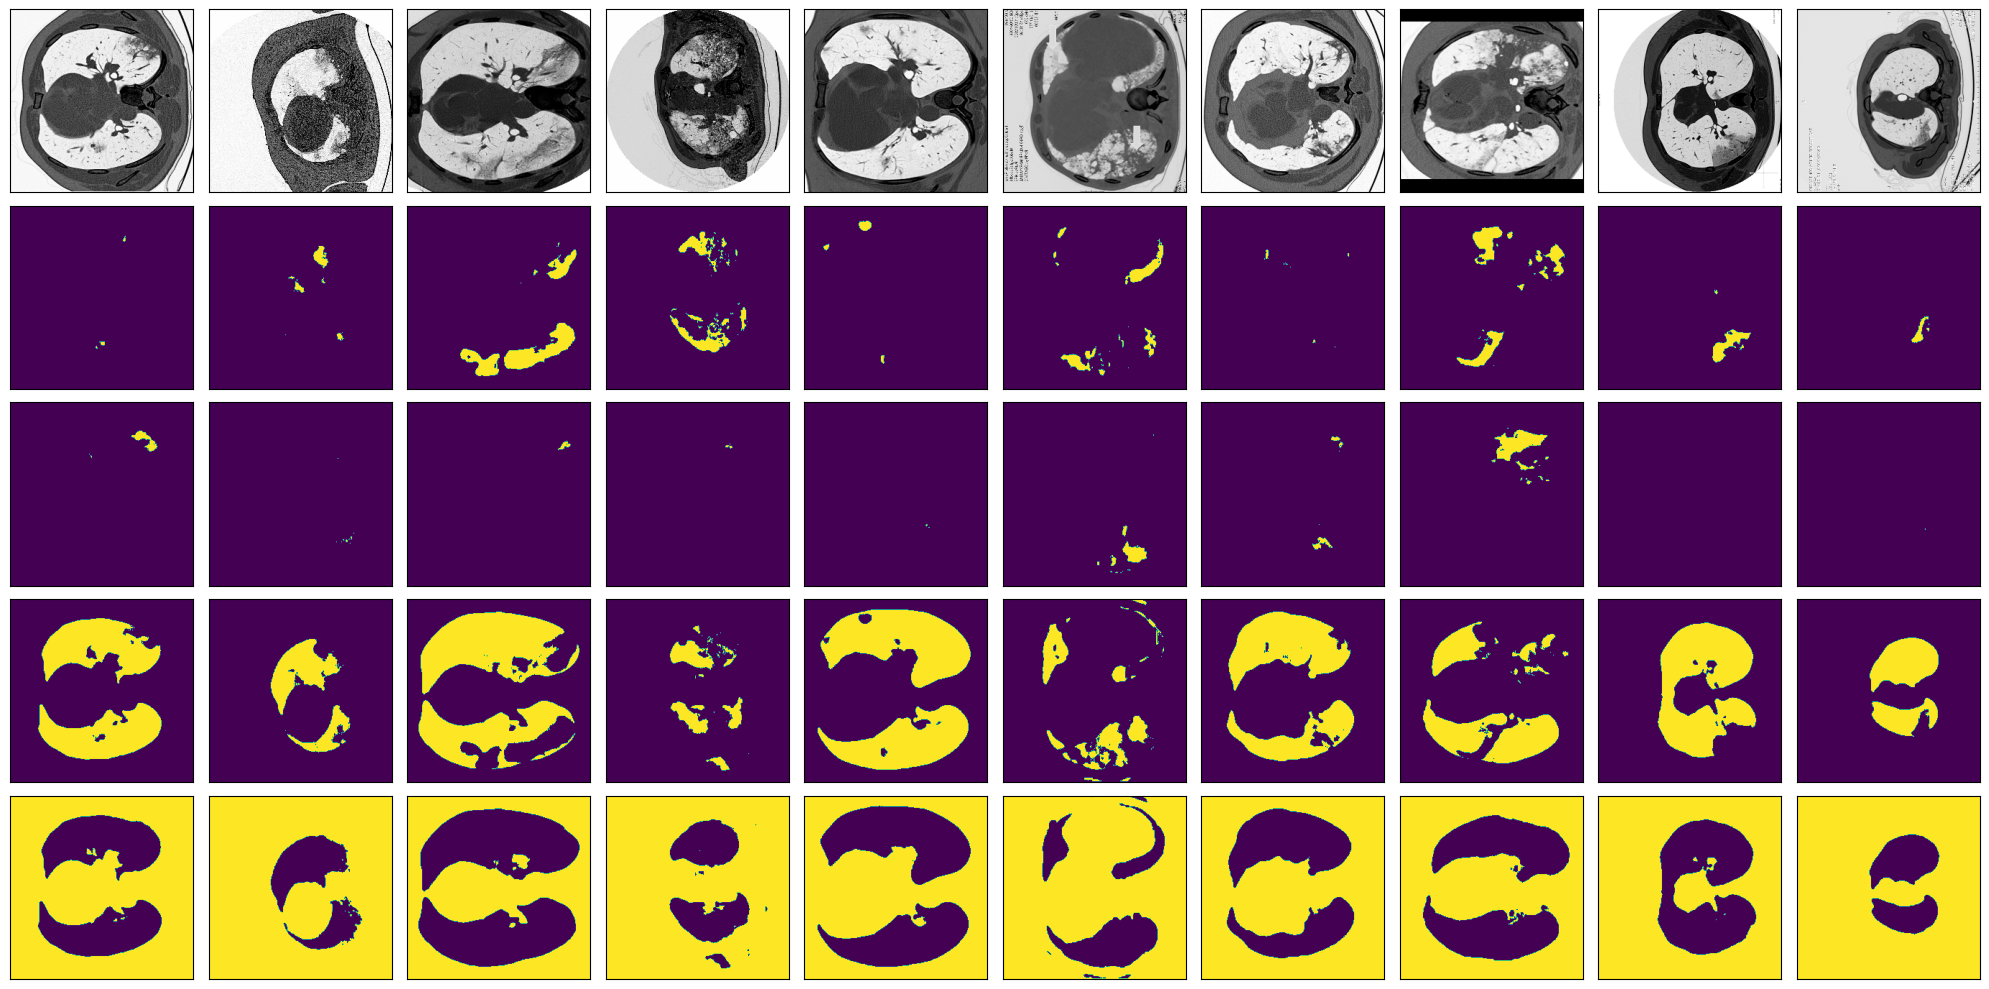

In [36]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[0].shape)

# Initialize the output array
output = np.zeros((10, 256, 256, 4))

# Predict and move the tensor to CPU before converting to numpy
for i in range(10):
    prediction = test_predict(model, image_batch[i])
    output[i] = prediction.cpu().numpy()  # Move to CPU and convert to numpy

print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

In [37]:
import scipy
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [38]:
import pandas as pd

pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('Kaggle/Output/sub.csv')